In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys
sys.path.append("..")
#sys.path.append(os.environ['DH_DIR'])
sys.path.append("/work/submit/yitians/darkhistory/DarkHistory")

from tqdm import tqdm
import time
import pickle
import h5py
import logging
import warnings

import numpy as np
from scipy import signal, ndimage, stats, interpolate, integrate
from astropy import cosmology, constants, units
from astropy.cosmology import Planck18
import jax
import jax.numpy as jnp
print(jax.devices())

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
mpl.rc_file('../matplotlibrc')

[CpuDevice(id=0)]


In [35]:
os.environ['DM21CM_DATA_DIR'] = '/data/submit/yitians/dm21cm/DM21cm/data'

In [166]:
import py21cmfast as p21c
from py21cmfast import plotting, cache_tools
print(f'Using 21cmFAST version {p21c.__version__}')
logging.getLogger('21cmFAST').setLevel(logging.INFO)
logging.getLogger().setLevel(logging.INFO)
logging.getLogger('py21cmfast._utils').setLevel(logging.CRITICAL+1)
logging.getLogger('py21cmfast.wrapper').setLevel(logging.CRITICAL+1)

from dm21cm.dm_params import DMParams
from dm21cm.data_loader import load_data
import dm21cm.physics as phys
from XRay_Development.field_smoother import WindowedData # move into dm21cm?

from darkhistory.spec.spectrum import Spectrum # use branch numpy issue
#from dm21cm.spec import Spectrum

Using 21cmFAST version 0.1.dev1578+g6f96f89.d20230224


## 0. Global config

In [5]:
! lscpu | grep "CPU(s)"

CPU(s):                48
On-line CPU(s) list:   0-47
NUMA node0 CPU(s):     0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46
NUMA node1 CPU(s):     1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47


In [6]:
N_THREADS = 32

In [7]:
def get_z_arr(z_start=None, z_end=20):
    
    if z_start is None:
        z_start = p21c.global_params.Z_HEAT_MAX
    z_arr = [z_end]
    while np.max(z_arr) < z_start:
        z_prev = (1 + np.max(z_arr)) * p21c.global_params.ZPRIME_STEP_FACTOR - 1
        z_arr.append(z_prev)
    return np.array(z_arr[::-1][1:])

In [9]:
# check cached runs
#CACHE_DIR_BASE = os.environ['P21C_CACHE_DIR']
CACHE_DIR_BASE = '/scratch/submit/ctp/yitians/21cmFAST-cache'
os.listdir(CACHE_DIR_BASE)

['emf_comp_dh_mh9',
 'phph_phbath_dhinit_Tk_dhinit_uniform',
 'phph_phbath_dhinit_Tk_dhinit_uniform_C1',
 'phph_dh_phbath_mh3_nophot',
 'phot_bath_no_prop',
 'phph_dh_phbath_mh3',
 'test',
 'emf_comp_base',
 'emf_comp_spf_mh3',
 'testdhph',
 'phph_spf_mh3',
 'base',
 'emf_comp_dh_mh6',
 'phph_dh_mh3',
 'emf_comp_dh_mh3',
 'phph_dh_phbath_mh3_dhinit',
 'phph_phbath_dhinit_Tk_dhinit',
 'turnon_phph']

## 1. Initialization

In [187]:
"""Docstring for all the switches.

========== run config ==========
run_name : str
use_tqdm : bool
save_slices : bool
    Whether to save slices of T_b, T_k, ... of run.

========== physics ==========
struct_boost_model : {'erfc 1e-3', 'erfc 1e-6', 'erfc 1e-9'}
run_mode : {'no inj', 'bath', 'xray'}
    'no inj' runs ye olde 21cmFAST, 'bath' treats every photon as if in bath. 'xray' treats xray seperately.
dhinit_list : list
    Which variables to initialize with DarkHistory, can include 'phot', 'T_k', 'x_e'.
    
========== debug ==========
DEBUG_ENABLE_ELEC : bool
    Electron transfer function not yet implemented.
DEBUG_RELOAD_TF : bool
    Whether to reload DarkHistoory transfer functions.
"""

run_name = 'xray_test_all_to_unif'
use_tqdm = False
save_slices = True

struct_boost_model = 'erfc 1e-3'
run_mode = 'xray'
dhinit_list = ['phot', 'T_k', 'x_e']

DEBUG_ENABLE_ELEC = False
DEBUG_RELOAD_TF = False

In [188]:
abscs = pickle.load(open('../data/abscissas/abscs_230408x.p', 'rb'))
photeng = abscs['photE']
eleceng = abscs['elecEk']

p21c.config['direc'] = f'{CACHE_DIR_BASE}/{run_name}'
os.makedirs(p21c.config['direc'], exist_ok=True)

In [189]:
cache_tools.clear_cache()

2023-06-16 14:47:36,203 | INFO | Removed 0 files from cache.
INFO:21cmFAST:Removed 0 files from cache.


In [190]:
! cp /scratch/submit/ctp/yitians/21cmFAST-cache/xray_test/dhinit_soln.p /scratch/submit/ctp/yitians/21cmFAST-cache/xray_test_all_to_unif/

In [75]:
! rm /scratch/submit/ctp/yitians/21cmFAST-cache/xray_bath_test/dhinit_soln.p

## 2. Loop

In [191]:
# redshift steps
p21c.global_params.ZPRIME_STEP_FACTOR = 1.05
p21c.global_params.Z_HEAT_MAX = 44.
z_edges = get_z_arr(z_end=6.)
z_mids = np.sqrt(z_edges[1:] * z_edges[:-1])
z_dh_stops = z_edges[1]
# p21c.global_params.CLUMPING_FACTOR = 1.

# dark matter
dm_params = DMParams(mode='swave', primary='phot_delta', m_DM=1e10, sigmav=1e-23)

# DarkHistory
if len(dhinit_list) > 0:
    dhinit_fn = f"{p21c.config['direc']}/dhinit_soln.p"
    
    if os.path.exists(dhinit_fn):
        dhinit_soln = pickle.load(open(dhinit_fn, 'rb'))
    else:
        logger.info('Running DarkHistory to generate initial conditions.')
        
        import main
        dhinit_soln = main.evolve(
            DM_process=dm_params.mode, mDM=dm_params.m_DM,
            sigmav=dm_params.sigmav, primary=dm_params.primary,
            struct_boost=phys.struct_boost_func(model=struct_boost_model),
            start_rs=3000, end_rs=(1+z_dh_stops), coarsen_factor=12, verbose=1
        )
        pickle.dump(dhinit_soln, open(dhinit_fn, 'wb'))

In [192]:
# 21cmFAST
initial_conditions = p21c.initial_conditions(
    user_params = p21c.UserParams(
        HII_DIM = 50, # [1]
        BOX_LEN = 50, # [p-Mpc]
        N_THREADS = N_THREADS
    ),
    cosmo_params = p21c.CosmoParams(
        OMm=0.32,
        OMb=0.049,
        POWER_INDEX=0.96,
        SIGMA_8=0.83,
        hlittle=0.67
    ),
    random_seed=54321, write=True
)
box_dim = initial_conditions.user_params.HII_DIM
box_len = initial_conditions.user_params.BOX_LEN

/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/inputs.py:488: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  "The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be "


In [194]:
# xray
ex_lo, ex_hi = 1e2, 1e4 # [eV]
ix_lo = np.searchsorted(photeng, ex_lo) # i of first bin greater than ex_lo, excluded
ix_hi = np.searchsorted(photeng, ex_hi) # i of first bin greater than ex_hi, included

def split_xray(phot_N):
    bath_N = np.array(phot_N).copy()
    xray_N = np.array(phot_N).copy()
    bath_N[ix_lo:ix_hi] *= 0
    xray_N[:ix_lo] *= 0
    xray_N[ix_hi:] *= 0
    return bath_N, xray_N

attenuation_arr = np.ones((len(z_mids), len(photeng))) # same locations as z_mids
xray_shell_Rmax = 0 # [Mpc]

In [195]:
# refresh xray structure
try:
    os.remove(p21c.config['direc']+'/xray_brightness.h5')
    logging.info('xray_brightness.h5 removed')
except:
    logging.info('xray_brightness.h5 not found')

xray_windowed_data = WindowedData(
    data_path=p21c.config['direc']+'/xray_brightness.h5',
    cosmo=Planck18,
    N=box_dim,
    dx=box_len / box_dim,
    cache=True,
)

# recording
records = []
input_time_tot = 0.
p21c_time_tot = 0.
    
if save_slices:
    saved_slices = []
    i_slice = int(box_dim/2)

if use_tqdm:
    pbar = tqdm(total=len(z_edges)-1, position=0)

    
for i_z in range(len(z_edges)):
    
    print(f'i_z={i_z}/{len(z_edges)}', flush=True)
    input_timer = time.time()
    
    #========== initialize ==========
    prop_phot_N = np.zeros_like(photeng) # [N / Bavg]
    emit_phot_N = np.zeros_like(photeng) # [N / Bavg]
    dep_box = np.zeros((box_dim, box_dim, box_dim, len(abscs['dep_c'],)))
    # last dimension: ('H ion', 'He ion', 'exc', 'heat', 'cont', 'xray')
    
    if i_z == 0:
        
        z = z_edges[i_z]
        # At this step we will arrive at z_edges[0], so z_mid is not defined yet.
        spin_temp = None
        input_heating = input_ionization = input_jalpha = None
        
        #----- load tfs -----
        phot_prop_tf = load_data('phot_prop', reload=DEBUG_RELOAD_TF)
        phot_scat_tf = load_data('phot_scat', reload=DEBUG_RELOAD_TF)
        phot_dep_tf = load_data('phot_dep', reload=DEBUG_RELOAD_TF)
        if DEBUG_ENABLE_ELEC:
            elec_phot_tf = load_data('elec_phot', reload=DEBUG_RELOAD_TF)
            elec_dep_tf = load_data('elec_dep', reload=DEBUG_RELOAD_TF)
        
        #----- initialize DM in_spec -----
        phot_prop_tf.set_fixed_in_spec(dm_params.inj_phot_spec.N)
        phot_scat_tf.set_fixed_in_spec(dm_params.inj_phot_spec.N)
        phot_dep_tf.set_fixed_in_spec(dm_params.inj_phot_spec.N)
        if DEBUG_ENABLE_ELEC:
            elec_phot_tf.set_fixed_in_spec(dm_params.inj_elec_spec.N)
            elec_dep_tf.set_fixed_in_spec(dm_params.inj_elec_spec.N)
        
        #----- initialize photon bath -----
        # note that photon bath also includes all uniform xray contributions
        if 'phot' in dhinit_list:
            dh_spec = dhinit_soln['highengphot'][-1] # [N per Bavg]
            phot_bath_spec = Spectrum(dh_spec.eng, dh_spec.N, rs=1+z_edges[0], spec_type='N')
        else:
            phot_bath_spec = Spectrum(photeng, np.zeros_like(photeng), rs=1+z_edges[0], spec_type='N') # [N per Bavg]
    
    
    else: # input from second step
        
        z = z_edges[i_z]
        z_mid = z_mids[i_z-1] # At this step we will arrive at z_edges[i], passing through z_mids[i-1].
        
        input_heating = p21c.input_heating(redshift=z, init_boxes=initial_conditions, write=False)
        input_ionization = p21c.input_ionization(redshift=z, init_boxes=initial_conditions, write=False)
        input_jalpha = p21c.input_jalpha(redshift=z, init_boxes=initial_conditions, write=False)
        
        if i_z == 1:
            if 'T_k' in dhinit_list:
                T_k_DH = dhinit_soln['Tm'][-1] / phys.kB # [K]
                spin_temp.Tk_box += T_k_DH - np.mean(spin_temp.Tk_box)
                # T_k_21cmfast = np.mean(spin_temp.Tk_box)
                # input_heating.input_heating += (T_k_DH - T_k_21cmfast) # old method of adjusting input boxes
            
            if 'x_e' in dhinit_list:
                x_e_DH = dhinit_soln['x'][-1, 0] # last step, HI
                spin_temp.x_e_box += x_e_DH - np.mean(spin_temp.x_e_box)
                # x_e_21cmfast = np.mean(1 - ionized_box.xH_box)
                # input_ionization.input_ionization += (x_e_DH - x_e_21cmfast) # old method of adjusting input boxes

        if run_mode == 'no inj':
            if i_z == 1:
                logging.warning('Not injecting anything in this run!')

        else:
            #========== calculate some quantities ==========
            z_prev = z_edges[i_z-1]
            dt = phys.dt_between_z(z_prev, z) # [s]
            if dm_params.mode == 'swave':
                struct_boost = phys.struct_boost_func(model=struct_boost_model)(1+z_mid)
            else:
                struct_boost = 1
            n_Bavg = phys.n_B * (1+z_mid)**3 # [Bavg cm^-3]
            
            #----- boxes -----
            delta_box = jnp.asarray(perturbed_field.density)
            B_per_Bavg = 1 + delta_box
            rho_DM_box = (1 + delta_box) * phys.rho_DM * (1+z_mid)**3 # [eV cm^-3]
            x_e_box = jnp.asarray(1 - ionized_box.xH_box)
            inj_per_Bavg_box = phys.inj_rate(rho_DM_box, dm_params) * dt * struct_boost / n_Bavg # [inj/Bavg]
            
            tf_kwargs = dict(
                rs = 1 + z_mid,
                nBs_s = (1+delta_box).ravel(),
                x_s = x_e_box.ravel(),
                out_of_bounds_action = 'clip',
            )
            
            #----- attenuation -----
            dep_tf_at_point = phot_dep_tf.point_interp(rs=1+z, nBs=1, x=np.mean(x_e_box))
            dep_toteng = np.sum(dep_tf_at_point[:, :4], axis=1)
            attenuation_arr[i_z-1, :] = 1 - dep_toteng/photeng
            
            #========== initialize ==========
            prop_phot_N = np.zeros_like(photeng) # [N / Bavg]
            emit_phot_N = np.zeros_like(photeng) # [N / Bavg]
            dep_box = np.zeros((box_dim, box_dim, box_dim, len(abscs['dep_c'],)))
            # last dimension: ('H ion', 'He ion', 'exc', 'heat', 'cont', 'xray')
            
            #========== photon bath -> prop emit dep ==========
            prop_phot_N += phot_prop_tf(
                in_spec=phot_bath_spec.N, sum_result=True, **tf_kwargs,
            ) / (box_dim ** 3) # [N / Bavg]
            
            emit_phot_N += phot_scat_tf(
                in_spec=phot_bath_spec.N, sum_result=True, **tf_kwargs,
            ) / (box_dim ** 3) # [N / Bavg]
            
            dep_box += phot_dep_tf(
                in_spec=phot_bath_spec.N, sum_result=False, **tf_kwargs,
            ).reshape(dep_box.shape) # [eV / Bavg]
            
            #========== DM (prompt phot+elec) -> emit dep ==========
            emit_phot_N += phot_prop_tf(
                in_spec=dm_params.inj_phot_spec.N, sum_result=True, sum_weight=inj_per_Bavg_box.ravel(), **tf_kwargs,
            ) / (box_dim ** 3) # [N / Bavg]
            
            emit_phot_N += phot_scat_tf(
                in_spec=dm_params.inj_phot_spec.N, sum_result=True, sum_weight=inj_per_Bavg_box.ravel(), **tf_kwargs,
            ) / (box_dim ** 3) # [N / Bavg]

            dep_box += phot_dep_tf(
                in_spec=dm_params.inj_phot_spec.N, sum_result=False, **tf_kwargs,
            ).reshape(dep_box.shape) * inj_per_Bavg_box[..., None] # [eV / Bavg]

            if DEBUG_ENABLE_ELEC:
                emit_phot_N += elec_phot_tf(
                    in_spec=dm_params.inj_elec_spec.N, sum_result=True, sum_weight=inj_per_Bavg_box.ravel(), **tf_kwargs,
                ) / (box_dim ** 3) # [N / Bavg]
                
                dep_box += elec_dep_tf(
                    in_spec=dm_params.inj_elec_spec.N, sum_result=False, **tf_kwargs,
                ).reshape(dep_box.shape) * inj_per_Bavg_box[..., None] # [eV / Bavg]
            
            #========== emitted xray (difference) -> emit dep ==========
            if run_mode == 'xray':
                
                xray_unif_N = np.zeros_like(photeng)
                
                for i_z_shell in range(2, i_z):
                    R1, R2 = xray_windowed_data.get_smoothing_radii(
                        z, z_edges[i_z_shell], z_edges[i_z_shell+1]
                    )
                    print(f'  i_z_shell={i_z_shell} {R2:.1f} -> {R1:.1f} Mpc', end='', flush=True)
                    
                    if np.max([R1, R2]) < xray_shell_Rmax:
                        xray_e_box, xray_N = xray_windowed_data.get_smoothed_shell(
                            z_receiver = z,
                            z_donor = z_edges[i_z_shell],
                            z_next_donor = z_edges[i_z_shell+1]
                        )
                        
                        xray_spec = Spectrum(photeng, xray_N, rs=z_edges[i_z_shell], spec_type='N') # [photon / Bavg]
                        for j in range(i_z_shell, i_z+1): # j is the i_z to get to.
                            xray_spec.N *= attenuation_arr[j-1]
                            xray_spec.redshift(1+z_edges[j])
                        # Note: xray_mean_eng = xray_spec.toteng() # unit: [eV / Bavg]
                        # Note: xray_e_box = local xray band energy / mean xray band energy
                        emit_phot_N += phot_scat_tf(
                            in_spec=xray_spec.N, sum_result=True, sum_weight=xray_e_box.ravel(), **tf_kwargs,
                        ) / (box_dim ** 3) # [N / Bavg]

                        dep_box += phot_dep_tf(
                            in_spec=xray_spec.N, sum_result=False, **tf_kwargs,
                        ).reshape(dep_box.shape) * xray_e_box[..., None] # [eV / Bavg] # CHECK SHAPE HERE
                        
                    else:
                        print(f' exceeding Rmax={xray_shell_Rmax}. Going into uniform.', end='', flush=True)
                        xray_N += xray_windowed_data.get_spec(
                            z_receiver = z,
                            z_donor = z_edges[i_z_shell],
                            z_next_donor = z_edges[i_z_shell+1]
                        )
                        
                        xray_spec = Spectrum(photeng, xray_N, rs=z_edges[i_z_shell], spec_type='N') # [photon / Bavg]
                        for j in range(i_z_shell, i_z+1): # j is the i_z to get to.
                            xray_spec.N *= attenuation_arr[j-1]
                            xray_spec.redshift(1+z_edges[j])
                            
                        xray_unif_N += xray_spec.N
                    
                    print('', flush=True)
                if not np.all(xray_unif_N == 0):
                    emit_phot_N += phot_scat_tf(
                        in_spec=xray_unif_N, sum_result=True, **tf_kwargs,
                    ) / (box_dim ** 3) # [N / Bavg]

                    dep_box += phot_dep_tf(
                        in_spec=xray_unif_N, sum_result=False, **tf_kwargs,
                    ).reshape(dep_box.shape) # [eV / Bavg] # CHECK SHAPE HERE
            else:
                pass # do nothing, because xray will be in photon bath already

            #========== update input_boxes ==========
            input_heating.input_heating += np.array(
                2 / (3*phys.kB*(1+x_e_box)) * dep_box[...,3] / B_per_Bavg
            ) # [K/Bavg] / [B/Bavg] = [K/B]
            input_ionization.input_ionization += np.array(
                (dep_box[...,0] + dep_box[...,1]) / phys.rydberg / B_per_Bavg
            ) # [1/Bavg] / [B/Bavg] = [1/B]
            
            n_lya = dep_box[...,2] * n_Bavg / phys.lya_eng # [lya cm^-3]
            dnu_lya = (phys.rydberg - phys.lya_eng) / (2*np.pi*phys.hbar) # [Hz^-1]
            J_lya = n_lya * phys.c / (4*np.pi) / dnu_lya # [lya cm^-2 s^-1 sr^-1 Hz^-1]
            input_jalpha.input_jalpha += np.array(J_lya)
            
            #========== record ==========
            dE_inj_per_Bavg = dm_params.eng_per_inj * np.mean(inj_per_Bavg_box) # [eV per Bavg]
            dE_inj_per_Bavg_unclustered = dE_inj_per_Bavg / struct_boost
            record_inj = {
                'dE_inj_per_B' : dE_inj_per_Bavg,
                'f_heat' : np.mean(dep_box[...,3]) / dE_inj_per_Bavg_unclustered,
                'f_ion'  : np.mean(dep_box[...,0] + dep_box[...,1]) / dE_inj_per_Bavg_unclustered,
                'f_exc'  : np.mean(dep_box[...,2]) / dE_inj_per_Bavg_unclustered,
            }
            
    input_time_tot += time.time() - input_timer

    #========== step in 21cmFAST ==========
    p21c_timer = time.time()
    perturbed_field = p21c.perturb_field( # perturbed_field controls the redshift
        redshift=z,
        init_boxes=initial_conditions
    )
    spin_temp = p21c.spin_temperature(
        perturbed_field=perturbed_field,
        previous_spin_temp=spin_temp,
        input_heating_box=input_heating,
        input_ionization_box=input_ionization,
        input_jalpha_box=input_jalpha,
        write=True
    )
    ionized_box = p21c.ionize_box(
        spin_temp=spin_temp
    )
    brightness_temp = p21c.brightness_temperature(
        ionized_box=ionized_box,
        perturbed_field=perturbed_field,
        spin_temp=spin_temp
    )
    coeval = p21c.Coeval(
        redshift = z,
        initial_conditions = initial_conditions,
        perturbed_field = perturbed_field,
        ionized_box = ionized_box,
        brightness_temp = brightness_temp,
        ts_box = spin_temp,
    )
    p21c_time_tot += time.time() - p21c_timer
    
    #========== prepare for next step ==========
    if i_z >= 1:
        if run_mode == 'xray':
            emit_bath_N, emit_xray_N = split_xray(emit_phot_N)
            out_phot_N = prop_phot_N + emit_bath_N

            # emit_xray_spec = Spectrum(photeng, emit_xray_N, rs=1+z, spec_type='N') 
            print(f'  xray band energy = {np.dot(photeng, emit_xray_N):.3e} = {np.mean(dep_box[..., 5]):.3e} eV / Bavg', flush=True)
            xray_e_box = dep_box[..., 5] / np.dot(photeng, emit_xray_N)
            # The mean energy for dep_box[..., 5] should be close to emit_xray_N.toteng()
            # for the above to work, every time emit_phot_N is populated, dep_box must be populated by the same input spectrum.
            xray_windowed_data.set_field(field=xray_e_box, spec=emit_xray_N, z=z)
            # xray_windowed_data.global_Tk = np.append(xray_windowed_data.global_Tk, np.mean(spin_temp.Tk_box))
            # xray_windowed_data.global_x = np.append(xray_windowed_data.global_x, np.mean(ionized_field.xH_box))
        else:
            out_phot_N = prop_phot_N + emit_phot_N # everything treated as uniform
    
        out_phot_spec = Spectrum(photeng, out_phot_N, rs=1+z, spec_type='N')    
        if z != z_edges[-1]:
            out_phot_spec.redshift(1+z_edges[i_z+1])
            phot_bath_spec = out_phot_spec

    #========== save results ==========
    if i_z > 0:
        record = {
            'z'   : z,
            'T_s' : np.mean(spin_temp.Ts_box), # [mK]
            'T_b' : np.mean(brightness_temp.brightness_temp), # [K]
            'T_k' : np.mean(spin_temp.Tk_box), # [K]
            'x_e' : np.mean(1 - ionized_box.xH_box), # [1]
        }
        if run_mode in ['bath', 'xray']:
            record.update(record_inj)
        records.append(record)
        
    if save_slices:
        saved_slices.append({
            'z'   : z,
            'T_s' : spin_temp.Ts_box[i_slice], # [mK]
            'T_b' : brightness_temp.brightness_temp[i_slice], # [K]
            'T_k' : spin_temp.Tk_box[i_slice], # [K]
            'x_e' : 1 - ionized_box.xH_box[i_slice], # [1]
            'delta' : perturbed_field.density[i_slice], # [1]
        })
        
    if use_tqdm:
        pbar.update()
        
#========== end of loop ==========
    
print(f'input used {input_time_tot:.4f} s')
print(f'p21c used {p21c_time_tot:.4f} s')

arr_records = {k: np.array([r[k] for r in records]) for k in records[0].keys()}
np.save(f'../data/run_info/{run_name}_records', arr_records)
if save_slices:
    np.save(f'../data/run_info/{run_name}_slices', saved_slices)

INFO:root:xray_brightness.h5 not found


i_z=0/39
i_z=1/39
  xray band energy = 3.265e-03 = 3.265e-03 eV / Bavg
i_z=2/39
  xray band energy = 3.009e-03 = 3.009e-03 eV / Bavg
i_z=3/39
  i_z_shell=2 0.0 -> 61.3 Mpc exceeding Rmax=0. Going into uniform.
  xray band energy = 2.799e-03 = 2.799e-03 eV / Bavg
i_z=4/39
  i_z_shell=2 62.8 -> 124.1 Mpc exceeding Rmax=0. Going into uniform.
  i_z_shell=3 0.0 -> 62.8 Mpc exceeding Rmax=0. Going into uniform.
  xray band energy = 2.640e-03 = 2.640e-03 eV / Bavg
i_z=5/39
  i_z_shell=2 127.2 -> 188.5 Mpc exceeding Rmax=0. Going into uniform.
  i_z_shell=3 64.4 -> 127.2 Mpc exceeding Rmax=0. Going into uniform.
  i_z_shell=4 0.0 -> 64.4 Mpc exceeding Rmax=0. Going into uniform.
  xray band energy = 2.543e-03 = 2.543e-03 eV / Bavg
i_z=6/39
  i_z_shell=2 193.2 -> 254.5 Mpc exceeding Rmax=0. Going into uniform.
  i_z_shell=3 130.4 -> 193.2 Mpc exceeding Rmax=0. Going into uniform.
  i_z_shell=4 66.0 -> 130.4 Mpc exceeding Rmax=0. Going into uniform.
  i_z_shell=5 0.0 -> 66.0 Mpc exceeding Rmax=

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
I

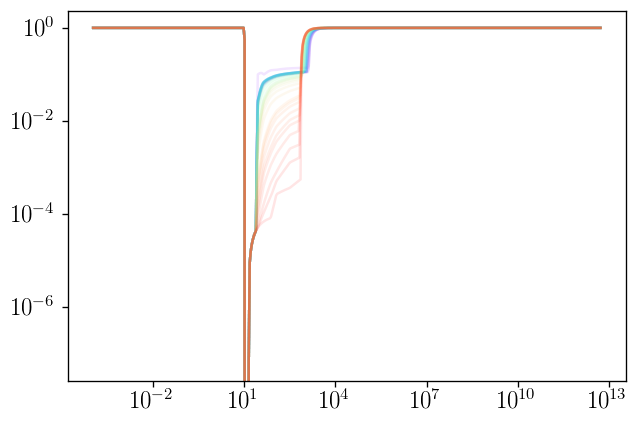

In [200]:
logging.getLogger().setLevel(logging.INFO+1)
fig, ax = plt.subplots()
for i, a in enumerate(attenuation_arr):
    ax.plot(photeng, a, alpha=0.1, color=mpl.colormaps['rainbow'](i/(len(attenuation_arr)-1)))
ax.set(xscale='log', yscale='log')
logging.getLogger().setLevel(logging.INFO)

## 3. Lightcone

In [29]:
import powerbox
# import importlib
# importlib.reload(powerbox)

In [39]:
lightcone = p21c.run_lightcone(
    redshift = z_edges[-1],
    user_params  = spin_temp.user_params,
    cosmo_params = spin_temp.cosmo_params,
    astro_params = spin_temp.astro_params,
    flag_options = spin_temp.flag_options,
)

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))
plotting.lightcone_sliceplot(lightcone, fig=fig, ax=ax)
ax.set(aspect=10)

In [40]:
def compute_power(
   box,
   length,
   n_psbins,
   log_bins=True,
   ignore_kperp_zero=True,
   ignore_kpar_zero=False,
   ignore_k_zero=False,
):
    # Determine the weighting function required from ignoring k's.
    k_weights = np.ones(box.shape, int)
    n0 = k_weights.shape[0]
    n1 = k_weights.shape[-1]

    if ignore_kperp_zero:
        k_weights[n0 // 2, n0 // 2, :] = 0
    if ignore_kpar_zero:
        k_weights[:, :, n1 // 2] = 0
    if ignore_k_zero:
        k_weights[n0 // 2, n0 // 2, n1 // 2] = 0

    res = powerbox.tools.get_power(
        box,
        boxlength=length,
        bins=n_psbins,
        bin_ave=False,
        get_variance=False,
        log_bins=log_bins,
        k_weights=k_weights,
    )

    res = list(res)
    k = res[1]
    if log_bins:
        k = np.exp((np.log(k[1:]) + np.log(k[:-1])) / 2)
    else:
        k = (k[1:] + k[:-1]) / 2

    res[1] = k
    return res

def powerspectra(brightness_temp, n_psbins=50, nchunks=20, min_k=0.1, max_k=1.0, logk=True):
    data = []
    chunk_indices = list(range(0,brightness_temp.n_slices,round(brightness_temp.n_slices / nchunks),))    
    
    if len(chunk_indices) > nchunks:
        chunk_indices = chunk_indices[:-1]
    chunk_indices.append(brightness_temp.n_slices)

    for i in range(nchunks):
        start = chunk_indices[i]
        end = chunk_indices[i + 1]
        chunklen = (end - start) * brightness_temp.cell_size

        power, k = compute_power(
            brightness_temp.brightness_temp[:, :, start:end],
            (BOX_LEN, BOX_LEN, chunklen),
            n_psbins,
            log_bins=logk,
        )
        data.append({"k": k, "delta": power * k ** 3 / (2 * np.pi ** 2)})
    return data

In [41]:
BOX_LEN = 50
HII_DIM = 50

k_fundamental = 2*np.pi / BOX_LEN
k_max = k_fundamental * HII_DIM
Nk = np.floor(HII_DIM/1).astype(int)

In [42]:
out = powerspectra(lightcone, min_k=k_fundamental, max_k=k_max)

In [43]:
pickle.dump(out, open(f'../data/run_info/{run_name}_ps', 'wb'))